In [ ]:
"""
deepfake_recognition Final Project
CS 555 AI
Spring 2025

Group 2
Members: Simardeep Khinda, Peter Nguyen, Jessica Sammons, Catharine Tew

This code was adapted with the help of Shradhdha Bhalodia's code at
https://www.kaggle.com/code/praveenraj001/deep-fake-image-classification-using-cnn
The dataset used in this code is provided on the Kaggle website:
https://www.kaggle.com/datasets/saurabhbagchi/deepfake-image-detection/data

In this project we use AI model to classify images as fake or real.
This code file loads the dataset, trains,
create a trained model file .keras, then does prediction on individual images.
The results include confusion matrix, accuracy, precision, recall, and F1 score.

"""

"""
this is the folder structure of a kaggle dataset

deepfake-image-detection
	Sample_fake_images
		Sample_fake_images
			fake
				IMG-20240106-WA0009.jpg
				...
	test-20250112T065939Z-001
		test
			fake
				...
			real
				...
	train-20250112T065955Z-001
		train
			fake
				...
			real
				...

"""

In [36]:
# Import Modules
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import glob
import numpy as np
import tensorflow
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
#Mouting a drive if using Google Colab, etc. "work_dir" in the next Code cell will need to be updated accordingly.
# E.g.)
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


# Load Data

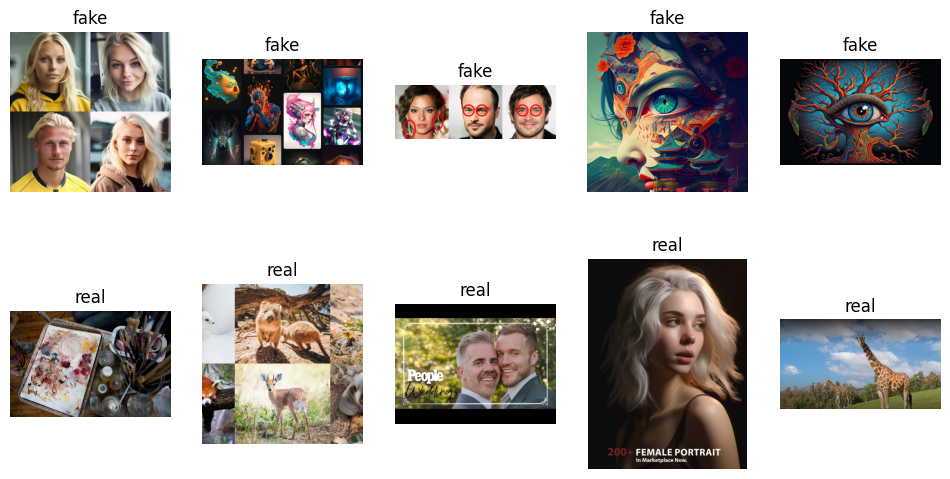

Found 479 images in 2 categories.
model.keras	    test-20250112T065939Z-001
Sample_fake_images  train-20250112T065955Z-001


In [52]:
###########################
# Load Data

# Set dataset path (update based on environment)
dataset_path = "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/train-20250112T065955Z-001/train"

"""
Load image paths and categories from the training dataset, display sample images.
Args:
    dataset_path (str): Path to the dataset folder containing category subfolders.
Returns:
    tuple: (img_paths, categories) where img_paths is a list of image file paths
            and categories is a list of category names.
"""
# List categories (fake & real)
categories = [category for category in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, category))]

# Collect all image paths and sample images for display
img_paths = []
sample_images = []
for category in categories:
    class_path = os.path.join(dataset_path, category)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img in images:
        img_path = os.path.join(class_path, img)
        img_paths.append((img_path, category))  # Store path and category
        if len(sample_images) < 10 and len([s for s, c in sample_images if c == category]) < 5:
            sample_images.append((img_path, category))  # Limit to 5 per category

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (img_path, label) in enumerate(sample_images):
    img = load_img(img_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")
plt.show()

print(f"Found {len(img_paths)} images in {len(categories)} categories.")
!ls "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection"

# Train CNN Model

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train shape: (344, 128, 128, 3), Validation shape: (39, 128, 128, 3), Test shape: (96, 128, 128, 3)


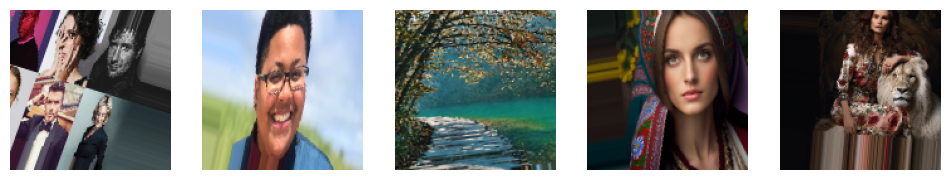

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6289 - loss: 0.8630 - val_accuracy: 0.6410 - val_loss: 0.6582
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6934 - loss: 0.6253 - val_accuracy: 0.6410 - val_loss: 0.6431
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6915 - loss: 0.6281 - val_accuracy: 0.6154 - val_loss: 0.6415
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7116 - loss: 0.5810 - val_accuracy: 0.6410 - val_loss: 0.6356
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7046 - loss: 0.5948 - val_accuracy: 0.6410 - val_loss: 0.6676
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6783 - loss: 0.6454 - val_accuracy: 0.6410 - val_loss: 0.6178
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6952 - loss: 0.5838 - val_accuracy: 0.6154 - val_loss: 0.7068
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7175 - loss: 0.5802 - val_accuracy: 0.6410 - val_loss:

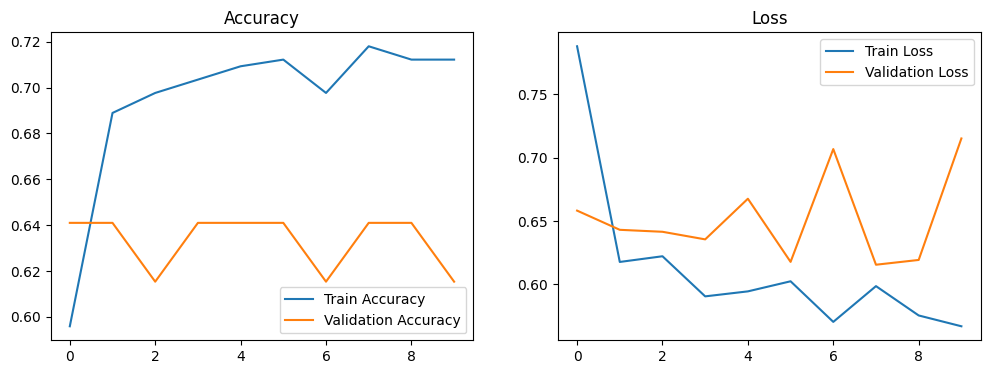

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.6576 - loss: 0.7668
Test Accuracy: 0.6667


In [53]:
###########################
# Train CNN Model

"""
Train a CNN model using the provided image paths and categories.
Args:
    img_paths (list): List of tuples (image_path, category).
    categories (list): List of category names.
Returns:
    model: Trained Keras model.
"""

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    return img_array

# Load all images and labels
image_data = []
labels = []
label_map = {category: idx for idx, category in enumerate(categories)}
for img_path, category in img_paths:
    image_data.append(load_and_preprocess_image(img_path))
    labels.append(label_map[category])

# Convert to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generate augmented images
augmented_images = datagen.flow(X_train[:5], batch_size=5)
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, img in enumerate(augmented_images):
    if i >= 1:
        break
    for j in range(5):
        axes[j].imshow(img[j])
        axes[j].axis("off")
plt.show()

# Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(X_val, y_val),
                    epochs=10,
                    verbose=1)

# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the trained model
model.save('/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/model.keras')

# Predictions & Results

In [ ]:
###########################
# Predictions and Results

In [58]:
# Get prediction of 1 image passed as link to file in google drive
def raw_predict(model, test_img_path):
    """
    Predict the class of a single test image.
    Args:
        model: Trained Keras model.
        test_img_path (str): Path to the test image.
    """
    input_img = load_img(test_img_path, target_size=(128, 128))
    input_array = img_to_array(input_img)
    input_array = np.expand_dims(input_array, axis=0)
    input_array = input_array / 255.0

    predictions = model.predict(input_array)
    print("Raw predictions (probabilities for each class):", predictions)

    predicted_class_idx = np.argmax(predictions, axis=-1)
    print(f"Predicted class index: {predicted_class_idx}")

    class_labels = ['fake', 'real']
    # Check if predicted_class_idx[0] is within the valid range
    if 0 <= predicted_class_idx[0] < len(class_labels):
        predicted_class_name = class_labels[predicted_class_idx[0]]
        print(f"Predicted class name: {predicted_class_name}")
    else:
        print(f"Warning: Predicted class index {predicted_class_idx[0]} is out of range.")
        print(f"Valid class indices are: 0 to {len(class_labels) - 1}")

    #Display that image
    img = load_img(test_img_path)
    plt.imshow(img)
    plt.axis("off")
    #plt.title("Image")
    plt.show()
#def evaluate_folders(model, folders_dict, class_labels=['fake', 'real']):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Raw predictions (probabilities for each class): [[0.25217924 0.7478208 ]]
Predicted class index: [1]
Predicted class name: real


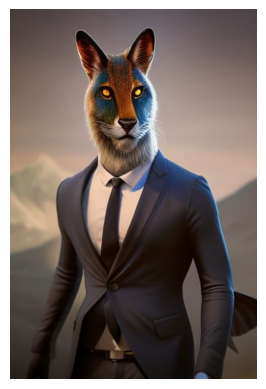

In [59]:
# Example test image path (update to a valid image from your dataset)
test_img_path = "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake/123.jpg"

raw_predict(model, test_img_path)



#format [fake, real]

In [54]:
class_labels = ['fake', 'real']

folder_label_map = {
    "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake": 0,
    "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/real": 1
}

"""
Evaluate the model on multiple folders of images and print aggregate results.

Args:
    model: Trained Keras model.
    folders_dict (dict): Dictionary mapping category labels to folder paths.
                          Example: {'fake': '/path/to/fake_images', 'real': '/path/to/real_images'}
    class_labels (list): List of class label strings, in the order corresponding to model outputs.
"""
IMG_SIZE = (128, 128)
true_labels = []
y_pred = []

#label_map = {label: idx for idx, label in enumerate(class_labels)}

for label, folder_path in folder_label_map.items():
    # The issue was here. You were assigning the value (0 or 1) to true_label
    # instead of the actual path.
    true_label = folder_label_map[label]

    # We need to use the key 'label' which contains the path as folder_path
    for img_file in os.listdir(label): # Using 'label' instead of 'folder_path'
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(label, img_file) # Using 'label' instead of 'folder_path'
            try:
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img) / 255.0
                input_array = np.expand_dims(img_array, axis=0)
                predictions = model.predict(input_array, verbose=0)
                predicted_class_idx = np.argmax(predictions, axis=-1)[0]
                true_labels.append(true_label)
                y_pred.append(predicted_class_idx)
            except Exception as e:
                print(f"Error with image {img_path}: {e}")


Evaluation Results on 499 images:
Accuracy:  0.2645
Precision: 0.7699
Recall:    0.2645
F1 Score:  0.1718


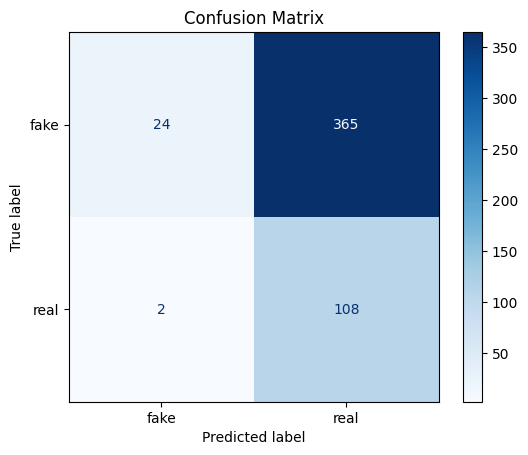


📊 Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.06      0.12       389
        real       0.23      0.98      0.37       110

    accuracy                           0.26       499
   macro avg       0.58      0.52      0.24       499
weighted avg       0.77      0.26      0.17       499



In [55]:
# Evaluation metrics
acc = accuracy_score(true_labels, y_pred)
prec = precision_score(true_labels, y_pred, average='weighted', zero_division=0)
rec = recall_score(true_labels, y_pred, average='weighted', zero_division=0)
f1 = f1_score(true_labels, y_pred, average='weighted', zero_division=0)

print(f"\nEvaluation Results on {len(true_labels)} images:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(true_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print("\n📊 Classification Report:")
print(classification_report(true_labels, y_pred, target_names=class_labels))